In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

## EDA

In [131]:
df = pd.read_csv("data/asu.tsv", sep="\t", comment="#", low_memory=False)
df = df[~df["HIP"].astype(str).str.contains("mag|-----", regex=True, na=False)].copy()
num_cols = ["HIP", "Vmag", "RAICRS", "DEICRS", "Plx", "pmRA", "pmDE", "e_Plx", "B-V", "_RA.icrs", "_DE.icrs", "BTmag", "VTmag", "Hpmag"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["Plx", "Vmag"]).reset_index(drop=True)

print(df.shape)
df.head()

(99767, 80)


,HIP,Proxy,RAhms,DEdms,Vmag,VarFlag,r_Vmag,RAICRS,DEICRS,AstroRef,...,BD,CoD,CPD,(V-I)red,SpType,r_SpType,HIPep,Erratum,_RA.icrs,_DE.icrs
0,1.0,,00 00 00.22,+01 05 20.4,9.10,,H,0.000912,1.089013,,...,B+00 5077,,,0.66,F5,S,HIPep,Erratum,0.000899,1.089009
1,2.0,,00 00 00.91,-19 29 55.8,9.27,,G,0.003797,-19.498837,+,...,B-20 6688,,,1.04,K3V,4,HIPep,Erratum,0.004265,-19.498840
2,3.0,,00 00 01.20,+38 51 33.4,6.61,,G,0.005008,38.859286,,...,B+38 5108,,,0.00,B9,S,HIPep,Erratum,0.005024,38.859279
3,4.0,,00 00 02.01,-51 53 36.8,8.06,,H,0.008382,-51.893546,,...,,,P-52 12237,0.43,F0V,2,HIPep,Erratum,0.008629,-51.893546
4,5.0,,00 00 02.39,-40 35 28.4,8.55,,H,0.009965,-40.591224,,...,,C-41 15372,P-41 9991,0.95,G8III,2,HIPep,Erratum,0.009973,-40.591202


In [132]:
# COL_PLX = "Plx"      # parallax in mas
# COL_V   = "Vmag"     # apparent V magnitude
# COL_BV  = "B-V"      # color index (may have NaNs)

# # keep rows with positive parallax (needed for distance)
# df = df.copy()
# df = df[pd.to_numeric(df[COL_PLX], errors="coerce") > 0].copy()

In [133]:
df.corr(numeric_only=True)

,HIP,Vmag,RAICRS,DEICRS,Plx,pmRA,pmDE,e_Plx,BTmag,VTmag,B-V,Hpmag,_RA.icrs,_DE.icrs
HIP,1.000000,-0.002974,0.999217,-0.044122,-0.005387,-0.140487,-0.008702,0.009126,0.007565,0.000445,0.016734,-0.003295,0.999217,-0.044122
Vmag,-0.002974,1.000000,-0.003638,0.009091,-0.060431,-0.003510,-0.044590,0.319088,0.884579,0.997127,0.077639,0.998182,-0.003638,0.009090
RAICRS,0.999217,-0.003638,1.000000,-0.043899,-0.005652,-0.140354,-0.008547,0.008243,0.007056,-0.000061,0.016473,-0.003960,1.000000,-0.043899
DEICRS,-0.044122,0.009091,-0.043899,1.000000,0.017732,0.004211,-0.038220,0.004172,0.014601,0.010080,0.017032,0.010016,-0.043899,1.000000
Plx,-0.005387,-0.060431,-0.005652,0.017732,1.000000,-0.074720,-0.214805,0.114136,-0.143223,-0.144907,0.026566,-0.058015,-0.005653,0.017730
pmRA,-0.140487,-0.003510,-0.140354,0.004211,-0.074720,1.000000,-0.106376,-0.000131,0.005681,0.003098,0.001348,-0.003422,-0.140350,0.004210
pmDE,-0.008702,-0.044590,-0.008547,-0.038220,-0.214805,-0.106376,1.000000,-0.025048,-0.020979,-0.011331,-0.044943,-0.046234,-0.008547,-0.038214
e_Plx,0.009126,0.319088,0.008243,0.004172,0.114136,-0.000131,-0.025048,1.000000,0.257861,0.297644,0.037717,0.316803,0.008243,0.004172
BTmag,0.007565,0.884579,0.007056,0.014601,-0.143223,0.005681,-0.020979,0.257861,1.000000,0.906520,0.493196,0.895099,0.007056,0.014601
VTmag,0.000445,0.997127,-0.000061,0.010080,-0.144907,0.003098,-0.011331,0.297644,0.906520,1.000000,0.084757,0.997078,-0.000061,0.010080


In [134]:
d = 1/df["Plx"]
d.describe()

/Users/dinarazhorabek/Projects/Fall25/astronomy_project/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    9.976700e+04
mean              inf
std               NaN
min     -1.000000e+02
25%      1.066098e-01
50%      1.992032e-01
75%      3.571429e-01
max               inf
Name: Plx, dtype: float64

There are infinity values for mean and max thus suggesting that there are "division by zero" occurring in the calculation. Hence, parallax with values zero or close to zero must be removed from the dataset to compute sensible distances. Parallaxes are close to zero for the stars that are much farther away.

Second there is a NaN for standard deviation which is not correct either. This hints at missing values for parallaxes in the datasets. We must take this into account too.

The minimum for the distance is a negative value indicative of the fact that there are negative parallaxes in the Hipparchos data. This must be taken into consideration too.

In [135]:
df_clean = df[df['Plx'].notna()]
df_clean = df_clean[df_clean.Plx > 0.1]
df_clean['d'] = 1/df_clean['Plx']
df_clean['d'].describe()

count    95757.000000
mean         0.350901
std          0.597950
min          0.001295
25%          0.115473
50%          0.206612
75%          0.363636
max          9.090909
Name: d, dtype: float64

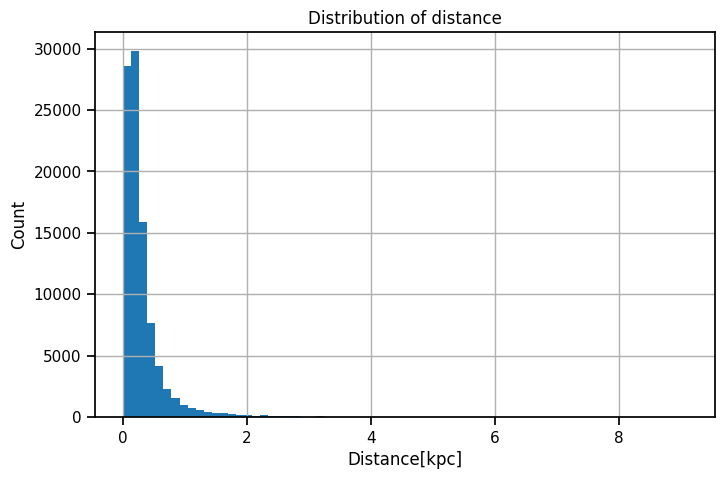

In [136]:
plt.figure(figsize=(8,5))
plt.hist(df_clean['d'], bins=70)
plt.title("Distribution of distance")
plt.xlabel("Distance[kpc]")
plt.ylabel("Count")
plt.show()

That is quite a skewed distribution of the distances involved. It is expected that most of the stars that are very far away will most likely be giant stars with large luminosities.

Mathematical reason: d=1/π is nonlinear (always positive, long right tail).

Observational reason: Hipparcos is magnitude-limited — many nearby stars, few distant ones.

Statistical reason: You filtered invalid/negative parallaxes, truncating the left side.

Spectral types (referred to as SpType in the catalog) of stars are a way to classify stars with the O-Type stars being the hottest and the M-Type stars being the coldest.

In [137]:
df_clean['SpType'].value_counts()

SpType
K0              7091
G5              5247
F8              3764
A0              3706
G0              3682
                ... 
K1II/IIICNp        1
F5 + A2            1
F2:V:              1
M1Ve+...           1
F7/G0 +F8/G2       1
Name: count, Length: 3500, dtype: int64

there are 3500 types of spectral types. Plotting this directly does not give us much information as seen below.

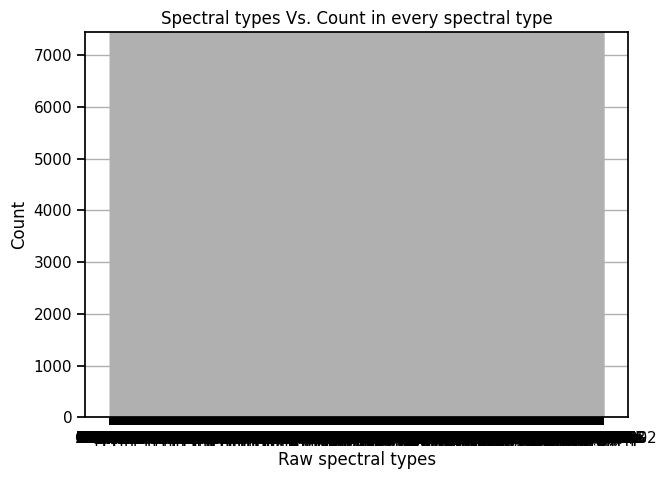

In [138]:
plt.bar(df_clean["SpType"].value_counts().index, df_clean["SpType"].value_counts())
plt.xlabel("Raw spectral types")
plt.ylabel("Count")
plt.title("Spectral types Vs. Count in every spectral type")
plt.show()

In [139]:
def get_sptype(sptype):
    O = B = A = F = G = K = M = 0
    for element in sptype.keys():
        if element[0] == 'O':
            O = O + sptype[element]
        elif element[0] == 'B':
            B = B + sptype[element]
        elif element[0] == 'A':
            A = A + sptype[element]
        elif element[0] == 'F':
            F = F + sptype[element]
        elif element[0] == 'G':
            G = G + sptype[element]
        elif element[0] == 'K':
            K = K + sptype[element]
        elif element[0] == 'M':
            M = M + sptype[element]
    return {"O": O, "B": B, "A": A, "F": F, "G": G, "K": K, "M": M}

In [140]:
sptype=df_clean['SpType'].value_counts().to_dict()
sptype = get_sptype(sptype)

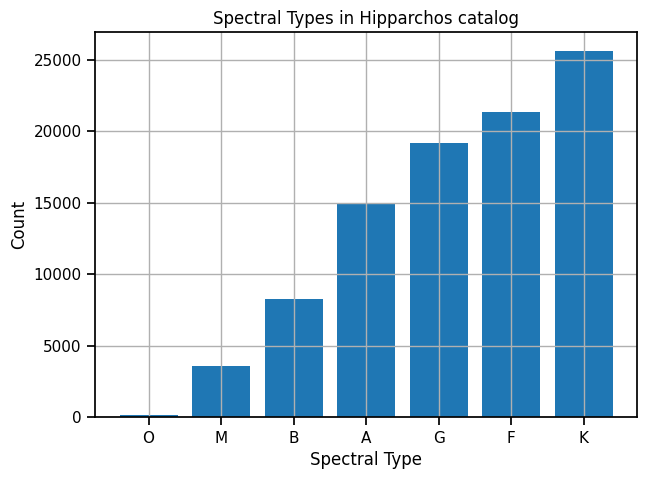

In [141]:
sptype_df = pd.DataFrame({
    "SpectralType": sptype.keys(),
    "Count": sptype.values()
})
sptype_df = sptype_df.sort_values("Count")
plt.bar(sptype_df['SpectralType'], sptype_df['Count'])
plt.xlabel("Spectral Type")
plt.ylabel("Count")
plt.title ("Spectral Types in Hipparchos catalog")
plt.show()

The population of the hotter stars is fairly less than the population of the colder stars with an exception of the M-class stars.

Perhaps the Hipparchos mission was biased towards the colder population of stars. Or is there a science behind this observation?

[Think about how stars evolve from their birth to death]

How do you explain the very low numbers of the M-type stars?

In [142]:
def get_new_sptype(sptype, spclass):
    class_0 = class_1 = class_2 = class_3 = class_4 = class_5 = class_6 = class_7 = class_8 = class_9 =0
    for element in sptype.keys():
        if len(element) == 1:
            continue
        if element[0] == spclass:
            if (ord(element[1]) >= 48 and ord(element[1]) <= 57): 
                if element[1] == "0":
                    class_0 = class_0 + sptype[element]
                if element[1] == "1":
                    class_1 = class_1 + sptype[element]
                if element[1] == "2":
                    class_2 = class_2 + sptype[element]
                if element[1] == "3":
                    class_3 = class_3 + sptype[element]
                if element[1] == "4":
                    class_4 = class_4 + sptype[element]
                if element[1] == "5":
                    class_5 = class_5 + sptype[element]
                if element[1] == "6":
                    class_6 = class_6 + sptype[element]
                if element[1] == "7":
                    class_7 = class_7 + sptype[element]
                if element[1] == "8":
                    class_8 = class_8 + sptype[element]
                if element[1] == "9":
                    class_9 = class_9 + sptype[element]
                
    return {"class0": class_0, "class1": class_1, "class2": class_2, "class3": class_3, "class4": class_4, "class5": class_5, "class6": class_6, "class7": class_7, "class8": class_8, "class9": class_9}

We can do same approach for each class from O to M, and add numbers. Since as we see the spectral type is combination of letters with numbers from 0 to 9.

In [143]:
spectral_type = ["O", "B", "A", "F", "G", "K", "M"]
spectral_class = []
sptype = df_clean["SpType"].value_counts()
sptype = sptype.to_dict()
for sp_type in spectral_type:
    sptype_count = get_new_sptype(sptype, sp_type)
    spectral_class.append(sptype_count)

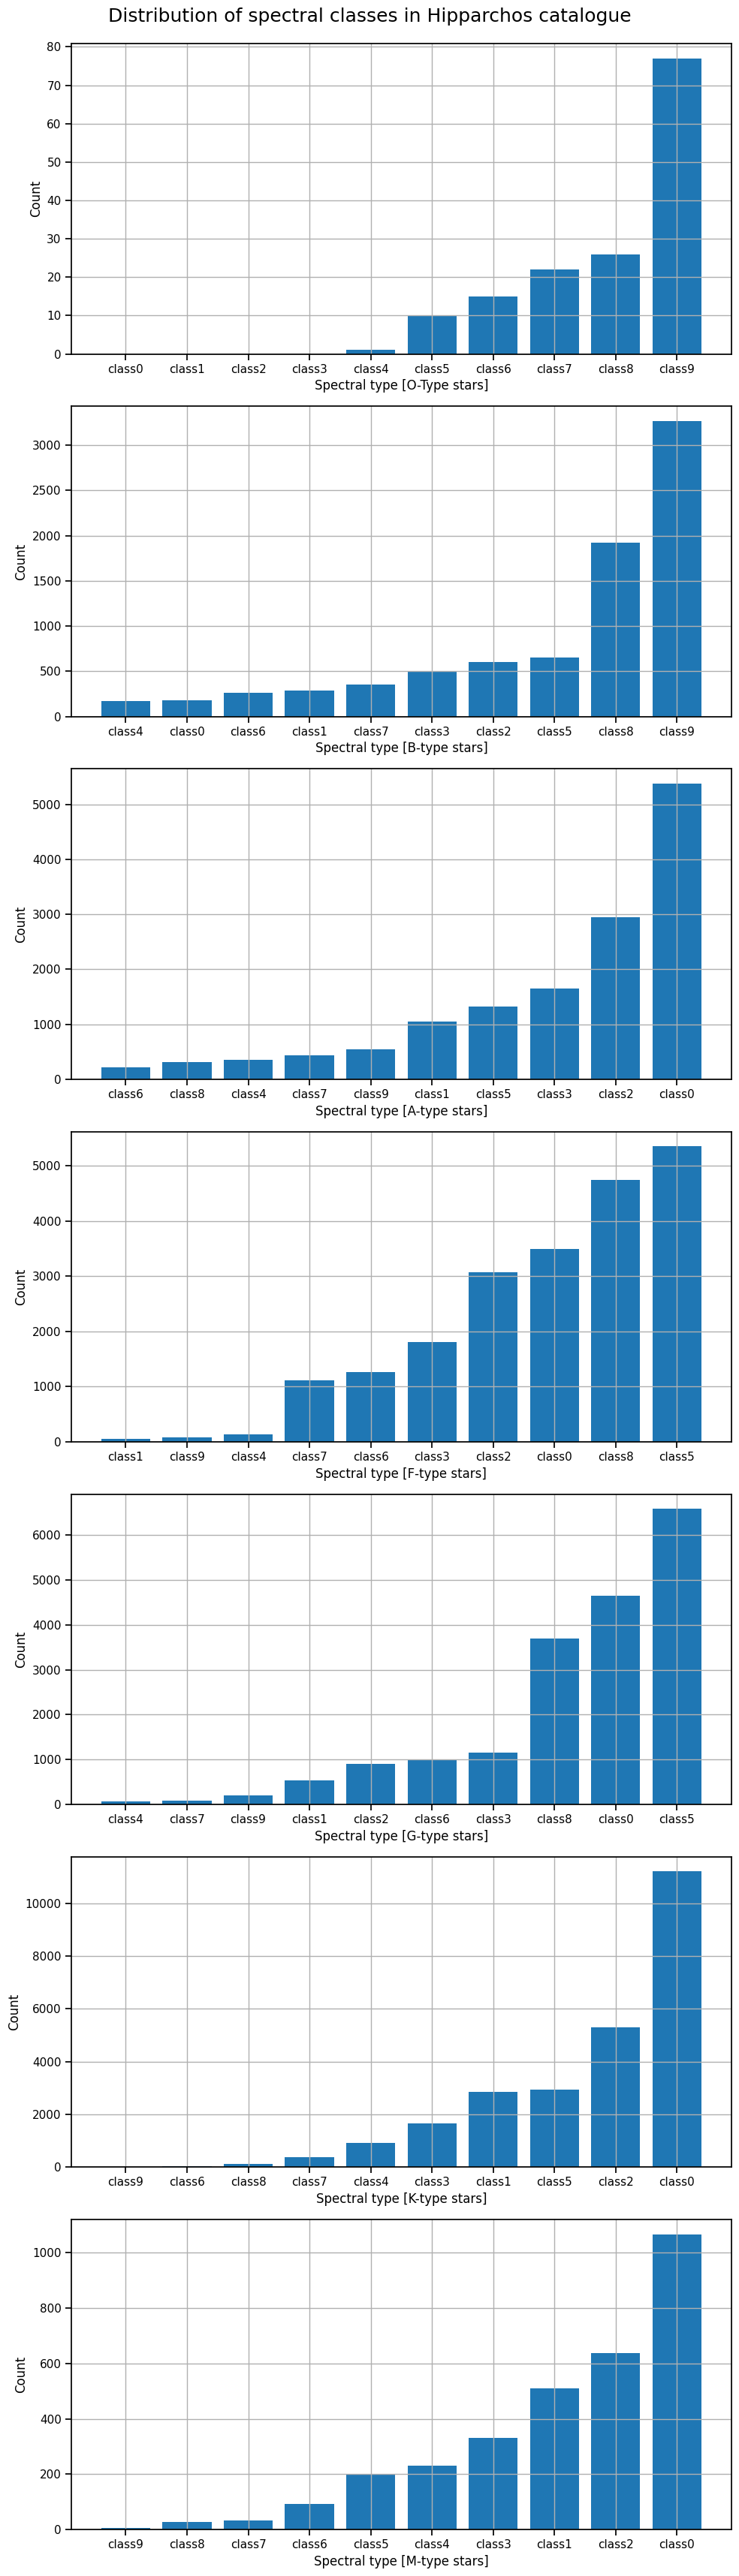

In [144]:
fig, ax = plt.subplots(7, 1, figsize = (10, 35))
fig.suptitle("Distribution of spectral classes in Hipparchos catalogue\n\n", fontsize = 18, 
             ha = "center")
plt_position = 0
spec_label = ["O-Type stars", "B-type stars", "A-type stars", "F-type stars", "G-type stars",
              "K-type stars", "M-type stars"]
for element in spectral_class:
    spectral_types = list(element.keys())
    type_values = list(element.values())
    data_df = pd.DataFrame({"Spectral_type": spectral_types,
                            "Type_counts": type_values})
    data_df = data_df.sort_values("Type_counts")
    ax[plt_position].bar(data_df["Spectral_type"], data_df["Type_counts"])
    ax[plt_position].set_xlabel("Spectral type [{}]".format(spec_label[plt_position]))
    ax[plt_position].set_ylabel("Count")
    plt_position += 1
plt.tight_layout() 
plt.show()

### Magnitude 

Text(0.5, 1.0, 'Distribution of the apparent visual magnitude')

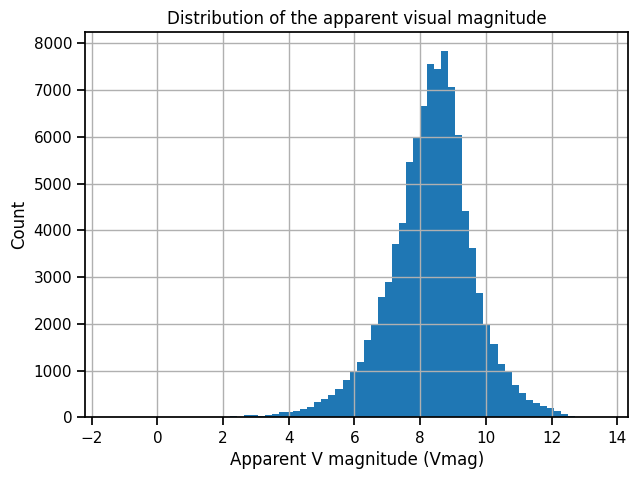

In [145]:
plt.hist(df_clean['Vmag'], bins=70)
plt.xlabel("Apparent V magnitude (Vmag)")
plt.ylabel("Count")
plt.title("Distribution of the apparent visual magnitude")

stars with vmag > 6 are the ones which cannot be seen by unaided eye.

But from the plot we see in our data the peak is around 8 and 9 values, which shows effectiveness of telescope.

In [146]:
df_clean.columns

Index(['HIP', 'Proxy', 'RAhms', 'DEdms', 'Vmag', 'VarFlag', 'r_Vmag', 'RAICRS',
       'DEICRS', 'AstroRef', 'Plx', 'pmRA', 'pmDE', 'e_RAICRS', 'e_DEICRS',
       'e_Plx', 'e_pmRA', 'e_pmDE', 'DE:RA', 'Plx:RA', 'Plx:DE', 'pmRA:RA',
       'pmRA:DE', 'pmRA:Plx', 'pmDE:RA', 'pmDE:DE', 'pmDE:Plx', 'pmDE:pmRA',
       'F1', 'F2', 'BTmag', 'e_BTmag', 'VTmag', 'e_VTmag', 'm_BTmag', 'B-V',
       'e_B-V', 'r_B-V', 'V-I', 'e_V-I', 'r_V-I', 'CombMag', 'Hpmag',
       'e_Hpmag', 'Hpscat', 'o_Hpmag', 'm_Hpmag', 'Hpmax', 'HPmin', 'Period',
       'HvarType', 'moreVar', 'morePhoto', 'CCDM', 'n_CCDM', 'Nsys', 'Ncomp',
       'MultFlag', 'Source', 'Qual', 'm_HIP', 'theta', 'rho', 'e_rho', 'dHp',
       'e_dHp', 'Survey', 'Chart', 'Notes', 'HD', 'BD', 'CoD', 'CPD',
       '(V-I)red', 'SpType', 'r_SpType', 'HIPep', 'Erratum', '_RA.icrs',
       '_DE.icrs', 'd'],
      dtype='object')

Text(0.5, 1.0, 'Distribution of the apparent visual magnitude')

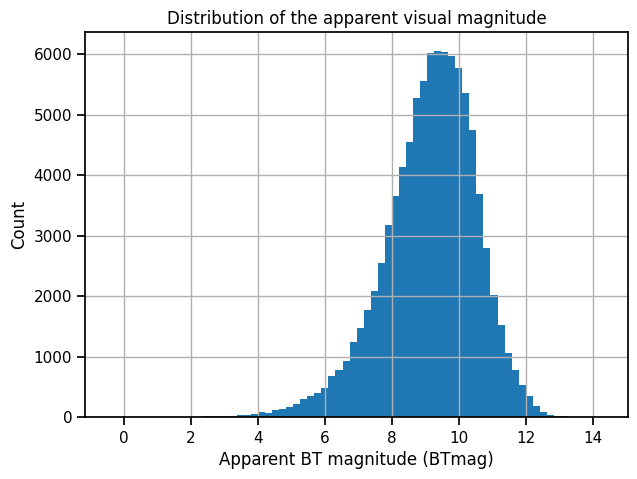

In [147]:
plt.hist(df_clean['BTmag'], bins=70)
plt.xlabel("Apparent BT magnitude (BTmag)")
plt.ylabel("Count")
plt.title("Distribution of the apparent visual magnitude")

Text(0.5, 1.0, 'Distribution of the apparent visual magnitude')

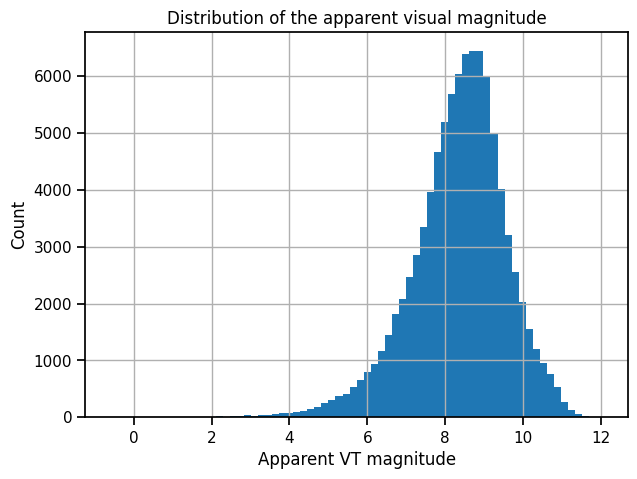

In [148]:
plt.hist(df_clean['VTmag'], bins=70)
plt.xlabel("Apparent VT magnitude")
plt.ylabel("Count")
plt.title("Distribution of the apparent visual magnitude")

Text(0.5, 1.0, 'Distribution of the apparent visual magnitude')

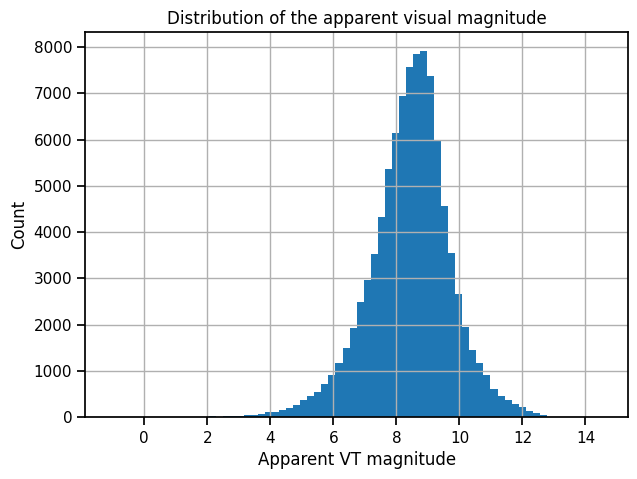

In [149]:
plt.hist(df_clean['Hpmag'], bins=70)
plt.xlabel("Apparent VT magnitude")
plt.ylabel("Count")
plt.title("Distribution of the apparent visual magnitude")

#### KDEPlots of the magnitude systems

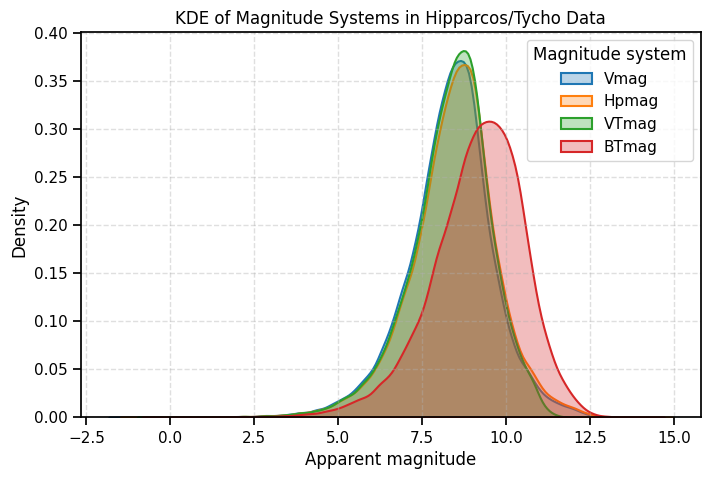

In [151]:
mag_cols = ["Vmag", "Hpmag", "VTmag", "BTmag"]

plt.figure(figsize=(8, 5))

# Plot each as a KDE (ignoring NaN values)
for col in mag_cols:
    if col in df_clean.columns:
        sns.kdeplot(df_clean[col].dropna(), label=col, fill=True, alpha=0.3, linewidth=1.5)

plt.xlabel("Apparent magnitude")
plt.ylabel("Density")
plt.title("KDE of Magnitude Systems in Hipparcos/Tycho Data")
plt.legend(title="Magnitude system")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

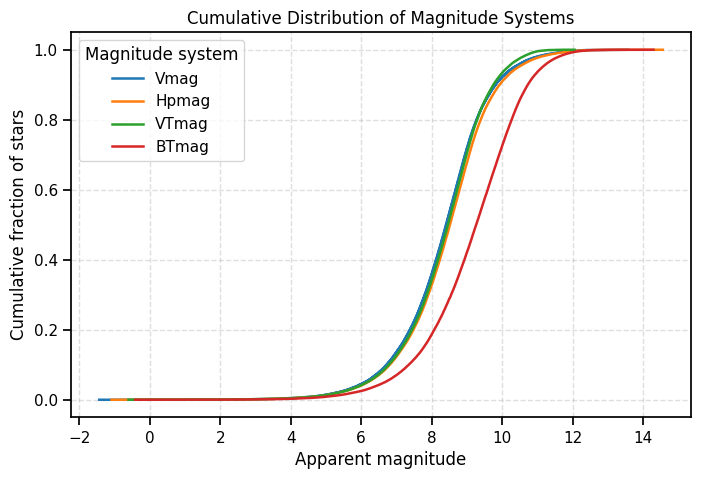

In [155]:
plt.figure(figsize=(8,5))
for col in mag_cols:
    if col in df_clean.columns:
        sorted_vals = np.sort(df_clean[col].dropna())
        cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
        plt.plot(sorted_vals, cdf, label=col, linewidth=1.8)

plt.xlabel("Apparent magnitude")
plt.ylabel("Cumulative fraction of stars")
plt.title("Cumulative Distribution of Magnitude Systems")
plt.legend(title="Magnitude system")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

All systems rise steeply between magnitude ~7–10, meaning most Hipparcos stars have apparent brightness in this range — consistent with its mission sensitivity limit (~12 mag).

BT curve (red line) shifts rightward, shows color dependent response of each photometric band. ??

### the variation of star brightness

In [161]:
df_clean['Period'] = pd.to_numeric(df_clean['Period'], errors="coerce")

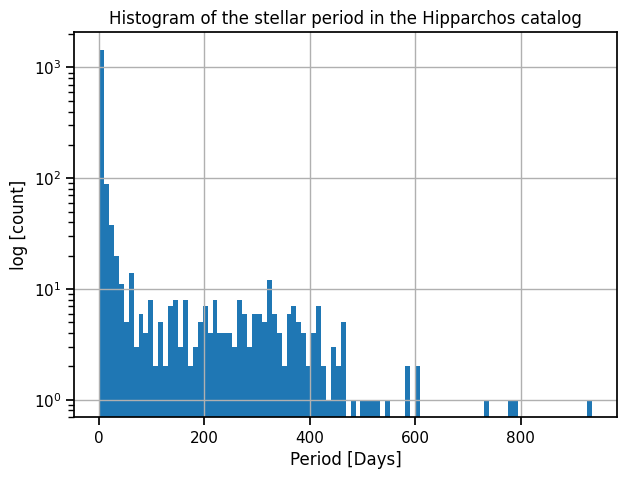

In [164]:
plt.hist(df_clean['Period'], bins=100, log=True)
plt.xlabel("Period [Days]")
plt.ylabel("log [count]")
plt.title("Histogram of the stellar period in the Hipparchos catalog")
plt.show()

histogram peaks at a variability period of 0 which indicates that most of the stars in the catalogue are not variable stars.

Related to the notion of the variability of stars, astronomers often divide the stars in different types of variability classes. This data helps us differentiate the type of variable stars and thus helps us in understanding the evolutionary tracks of these stars. Remember, after the main sequence comes to an end, the stars could be on any of the evolutionary tracks characterized by different features.

In [167]:
hvartype_df = pd.DataFrame({
    "sources":df_clean['HvarType'].value_counts().index,
    "count": df_clean['HvarType'].value_counts().values
})
hvartype_df = hvartype_df.sort_values("count")

how to handle missing values?


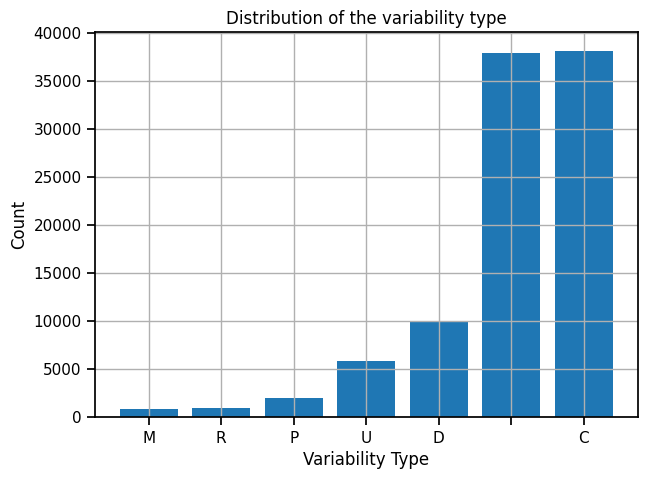

In [168]:
plt.bar(hvartype_df["sources"], hvartype_df["count"])
plt.xlabel("Variability Type")
plt.ylabel("Count")
plt.title("Distribution of the variability type")
plt.show()

The variability types means the following,

C : no variability detected ("constant")

D : duplicity-induced variability

M : possibly micro-variable, with amplitude < 0.03 mag (stars classified with high confidence as micro-variable are flagged U)

P : periodic variable

R : the V-I color index was revised during the variability analysis

U : unsolved variable which does not fall in the other categories; this class also includes irregular or semi-regular variables, and possibly variables with amplitude > or ~ 0.03 mag

This is in alignment with what we observe in the variability histogram where most of the stars were seen as the ones that are not variable (Type C: no variability detected)

### HR diagram

In [170]:
df_clean['Vmag'].isna().sum()

np.int64(0)

In [171]:
df_clean['B-V'].isna().sum()

np.int64(770)

We see that the column Vmag does not have null values while the column B-V color has null values which must be removed for a cleaner plot.

In [172]:
df_clean = df_clean[df_clean['B-V'].notna()]
df_clean.shape

(94987, 81)

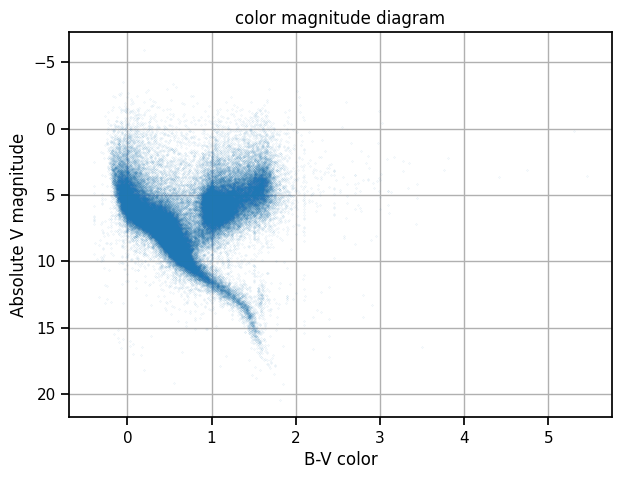

In [173]:
distance = df_clean["d"] * 1000 #Obtaining the distance in parsecs
distance_modulus = 5 * (np.log10(distance / 10) - 1) #Calculate the distance modulus
abs_v_mag = df_clean["Vmag"] - distance_modulus #Get the absolute V magnitude of the sources
plt.plot(df_clean["B-V"], abs_v_mag, marker='.', linestyle='none', alpha=0.3, markersize = 0.3)
plt.gca().invert_yaxis()
plt.xlabel("B-V color")
plt.ylabel("Absolute V magnitude")
plt.title("color magnitude diagram")
plt.show()

next to plot HR diagram we need to calculate effective temperature, to do that we will use Ballesteros' formula

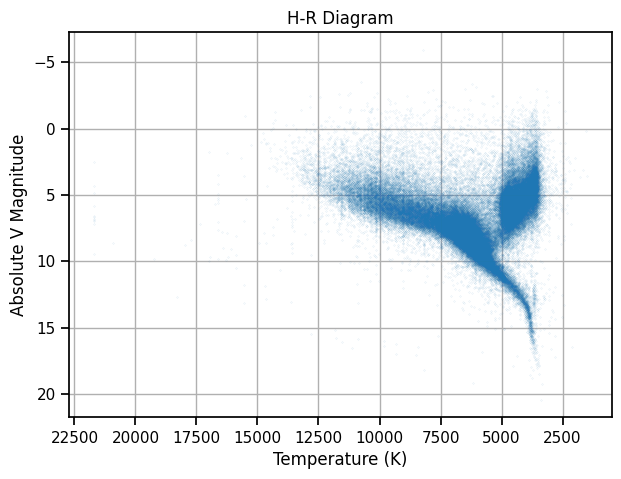

In [174]:
temperature = 4600 * (1/(0.92 * df_clean['B-V'] + 1.7) + 1/(0.92 * df_clean['B-V'] + 0.62)) #Ballesteros formula
plt.plot(temperature, abs_v_mag, marker='.', linestyle='none', alpha=0.3, markersize = 0.3)
plt.xlabel('Temperature (K)')
plt.ylabel("Absolute V Magnitude")
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.title("H-R Diagram")
plt.show()

#### H-R Diagram (V-I color and V magnitute)

In [180]:
df_clean['V-I'] = pd.to_numeric(df_clean['V-I'], errors="coerce")

In [181]:
df_clean['V-I'].isna().sum()

np.int64(0)

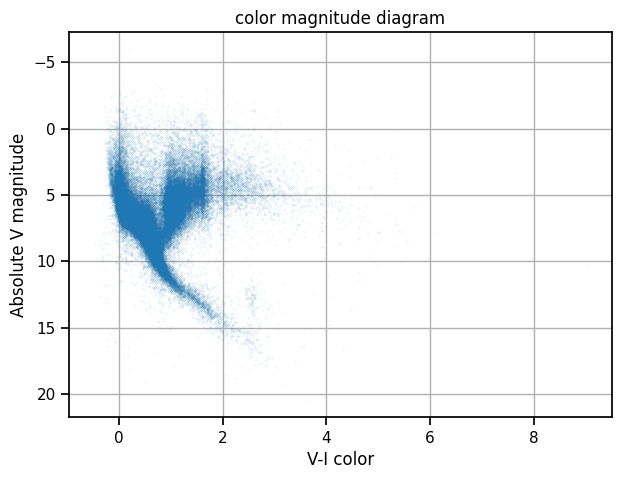

In [182]:
distance = df_clean["d"] * 1000 #Obtaining the distance in parsecs
distance_modulus = 5 * (np.log10(distance / 10) - 1) #Calculate the distance modulus
abs_v_mag = df_clean["Vmag"] - distance_modulus #Get the absolute V magnitude of the sources
plt.plot(df_clean["V-I"], abs_v_mag, marker='.', linestyle='none', alpha=0.3, markersize = 0.3)
plt.gca().invert_yaxis()
plt.xlabel("V-I color")
plt.ylabel("Absolute V magnitude")
plt.title("color magnitude diagram")
plt.show()

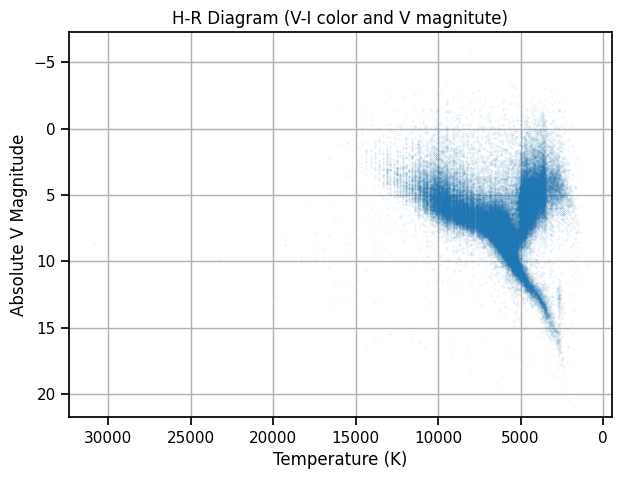

In [184]:
temperature = 4600 * (1/(0.92 * df_clean['V-I'] + 1.7) + 1/(0.92 * df_clean['V-I'] + 0.62)) #Ballesteros formula
plt.plot(temperature, abs_v_mag, marker='.', linestyle='none', alpha=0.3, markersize = 0.3)
plt.xlabel('Temperature (K)')
plt.ylabel("Absolute V Magnitude")
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.title("H-R Diagram (V-I color and V magnitute)")
plt.show()

now the temperature range changed

## Classification

In [185]:
df_clean.columns

Index(['HIP', 'Proxy', 'RAhms', 'DEdms', 'Vmag', 'VarFlag', 'r_Vmag', 'RAICRS',
       'DEICRS', 'AstroRef', 'Plx', 'pmRA', 'pmDE', 'e_RAICRS', 'e_DEICRS',
       'e_Plx', 'e_pmRA', 'e_pmDE', 'DE:RA', 'Plx:RA', 'Plx:DE', 'pmRA:RA',
       'pmRA:DE', 'pmRA:Plx', 'pmDE:RA', 'pmDE:DE', 'pmDE:Plx', 'pmDE:pmRA',
       'F1', 'F2', 'BTmag', 'e_BTmag', 'VTmag', 'e_VTmag', 'm_BTmag', 'B-V',
       'e_B-V', 'r_B-V', 'V-I', 'e_V-I', 'r_V-I', 'CombMag', 'Hpmag',
       'e_Hpmag', 'Hpscat', 'o_Hpmag', 'm_Hpmag', 'Hpmax', 'HPmin', 'Period',
       'HvarType', 'moreVar', 'morePhoto', 'CCDM', 'n_CCDM', 'Nsys', 'Ncomp',
       'MultFlag', 'Source', 'Qual', 'm_HIP', 'theta', 'rho', 'e_rho', 'dHp',
       'e_dHp', 'Survey', 'Chart', 'Notes', 'HD', 'BD', 'CoD', 'CPD',
       '(V-I)red', 'SpType', 'r_SpType', 'HIPep', 'Erratum', '_RA.icrs',
       '_DE.icrs', 'd'],
      dtype='object')

In [202]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [235]:
features = ["Plx","Vmag","BTmag","VTmag","B-V","V-I","Hpmag","HvarType"]
data = df_clean[features].dropna(axis=0)
data = data[data['HvarType'].notna() & (data['HvarType'].astype(str).str.strip() != '')]
data1 = data.drop(["HvarType"],axis=1).copy()

data1.shape
data['HvarType'].value_counts()
# X = df[features].values

HvarType
C    37744
D     9439
U     5637
P     1863
M      894
R      884
Name: count, dtype: int64

In [236]:
X = data1.values
le = LabelEncoder()
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = le.fit_transform(data['HvarType'].values)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=79, stratify=Y)

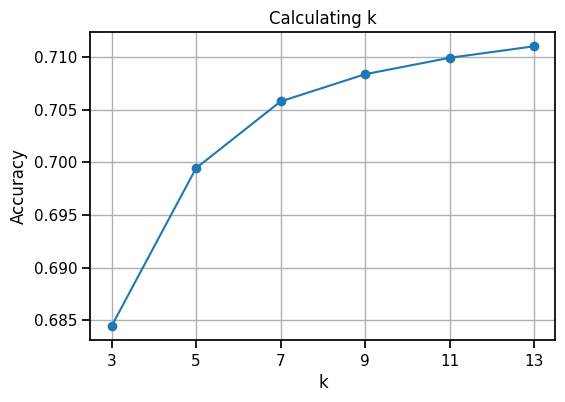

In [ ]:
# kNN
accs = []
k_values = [3,5,7,9,11,13]
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, Y_train)
    acc = knn_classifier.score(X_test, Y_test)
    accs.append(acc)

plt.figure(figsize=(6,4))
plt.plot(k_values, accs, marker='o')
plt.xticks(k_values)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Calculating k')
plt.grid(True)
plt.show()


In [ ]:
knn_best = KNeighborsClassifier(n_neighbors=9)
knn_best.fit(X_train, Y_train)
y_pred = knn_best.predict(X_test)

print(classification_report(Y_test, y_pred, target_names=le.classes_))

k=KNeighborsClassifier(n_neighbors=9)
              precision    recall  f1-score   support

           C       0.72      0.97      0.83     18872
           D       0.39      0.06      0.11      4720
           M       0.39      0.16      0.22       447
           P       0.26      0.03      0.05       931
           R       0.67      0.05      0.09       442
           U       0.74      0.43      0.54      2819

    accuracy                           0.71     28231
   macro avg       0.53      0.28      0.31     28231
weighted avg       0.65      0.71      0.63     28231



#### Logistic Regression

In [216]:
# logreg
from sklearn.linear_model import LogisticRegression

X = data1.values
le = LabelEncoder()
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = le.fit_transform(data['HvarType'].values)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=79, stratify=Y)

log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(X_train, Y_train)

/Users/dinarazhorabek/Projects/Fall25/astronomy_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [218]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 12),
    cv=5,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=[0.0, 0.5, 1.0],      # ridge / elastic / lasso
    multi_class="multinomial",
    class_weight="balanced",        # helps with rare classes
    scoring="f1_macro",             # better than accuracy for imbalance
    max_iter=5000,
    n_jobs=-1,
    refit=True
).fit(X_train, Y_train)

print("Best C:", clf.C_[0], " Best l1_ratio:", clf.l1_ratio_[0])
print("CV f1_macro (train):", clf.score(X_train, Y_train))
print("f1_macro (test):", clf.score(X_train, Y_train))

/Users/dinarazhorabek/Projects/Fall25/astronomy_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/dinarazhorabek/Projects/Fall25/astronomy_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dinarazhorabek/Projects/Fall25/astronomy_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dinarazhorabek/Projects/Fall25/astronomy_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Best C: 100.0  Best l1_ratio: 1.0
CV f1_macro (train): 0.2242357424564313
f1_macro (test): 0.2242357424564313


In [220]:
coef = clf.coef_            # shape: [n_classes, n_features]
feat_importance = pd.DataFrame(
    np.abs(coef).T, columns=[f"class_{i}" for i in range(coef.shape[0])],
    index=["Plx","Vmag","BTmag","VTmag","B-V","V-I","Hpmag"]
).assign(mean_abs=lambda d: d.mean(axis=1)).sort_values("mean_abs", ascending=False)

print(feat_importance.round(3))


       class_0  class_1  class_2  class_3  class_4  class_5  mean_abs
Hpmag    8.290    5.383    3.910    6.125    2.823    6.802     5.556
Vmag     6.677    4.528    5.066    5.689    1.998    5.102     4.843
VTmag    1.959    0.972    2.786    3.961    0.162    4.058     2.316
BTmag    1.789    0.807    1.753    3.130    1.329    1.758     1.761
V-I      1.170    0.006    0.845    1.230    0.155    1.114     0.753
B-V      0.020    0.090    0.498    0.003    0.247    0.177     0.173
Plx      0.009    0.110    0.048    0.297    0.130    0.236     0.138


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# Training routine
def train_model(X_train, X_test, Y_train, Y_test, model, verbose=False, **params):

    clf = model(**params)
    clf.fit(X_train,Y_train)
    predictions = clf.predict(X_test)
    acc_train, acc_test = accuracy_score(Y_train, clf.predict(X_train)), accuracy_score(Y_test, predictions)
    if verbose:
        print("Train accuracy: {:.2f}, Test accuracy: {:.2f}".format(acc_train, acc_test))
        print(confusion_matrix(Y_test, predictions))
        print(classification_report(Y_test, predictions))
    return acc_test

In [239]:
# Train the model performing a search
n_ests = range(10, 110, 10)

best_acc, best_nest = 0., 1
for n_est in n_ests:
    print("Random Forest, estimators:", n_est)
    acc_test = train_model(X_train, X_test, Y_train, Y_test, RandomForestClassifier, n_estimators=n_est)
    if acc_test>best_acc:
        best_acc = acc_test
        best_nest = n_est
        print("Test accuracy: {:.2f}".format(acc_test))
        
# Show results for the best model
print("Best model, estimators:", best_nest)
train_model(X_train, X_test, Y_train, Y_test, RandomForestClassifier, n_estimators=best_nest, verbose=True)

Random Forest, estimators: 10
Test accuracy: 0.70
Random Forest, estimators: 20
Test accuracy: 0.71
Random Forest, estimators: 30
Test accuracy: 0.71
Random Forest, estimators: 40
Test accuracy: 0.71
Random Forest, estimators: 50
Test accuracy: 0.71
Random Forest, estimators: 60
Test accuracy: 0.72
Random Forest, estimators: 70
Random Forest, estimators: 80
Random Forest, estimators: 90
Random Forest, estimators: 100
Test accuracy: 0.72
Best model, estimators: 100
Train accuracy: 1.00, Test accuracy: 0.72
[[18066   460    34    69     8   235]
 [ 3873   720    21    27    12    67]
 [  250    27    68    16     0    86]
 [  646    74    24    46     0   141]
 [  291    59     0     1    46    45]
 [ 1334   111    42    26     3  1303]]
              precision    recall  f1-score   support

           0       0.74      0.96      0.83     18872
           1       0.50      0.15      0.23      4720
           2       0.36      0.15      0.21       447
           3       0.25      0.05    

0.7172611668024512

In [240]:
# Create a pipeline with a PCA and a random forest classifier
from sklearn import decomposition, preprocessing, model_selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
estimators = [('reduce_dim', decomposition.PCA()), ('randomforest', RandomForestClassifier())]
pipe = Pipeline(estimators)

# Create a grid search, considering different hyperparameters
param_grid = dict(reduce_dim__n_components=[3],randomforest__n_estimators=[30, 40, 50, 60, 70, 80], randomforest__max_depth=[10,20,30,None])
clf = GridSearchCV(pipe, param_grid=param_grid)
clf.fit(X_train, Y_train)
print(clf.best_params_)
predictions = clf.predict(X_test)
acc_train, acc_test = accuracy_score(Y_train, clf.predict(X_train)), accuracy_score(Y_test, predictions)

print("Train accuracy: {:.2f}, Test accuracy: {:.2f}".format(acc_train, acc_test))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

{'randomforest__max_depth': 10, 'randomforest__n_estimators': 80, 'reduce_dim__n_components': 3}
Train accuracy: 0.73, Test accuracy: 0.71
[[18696    14    16     8     0   138]
 [ 4651    25     9     3     0    32]
 [  278     8    46    11     0   104]
 [  771     3    15     7     0   135]
 [  406     1     0     0     0    35]
 [ 1512    10    29     7     0  1261]]
              precision    recall  f1-score   support

           0       0.71      0.99      0.83     18872
           1       0.41      0.01      0.01      4720
           2       0.40      0.10      0.16       447
           3       0.19      0.01      0.01       931
           4       0.00      0.00      0.00       442
           5       0.74      0.45      0.56      2819

    accuracy                           0.71     28231
   macro avg       0.41      0.26      0.26     28231
weighted avg       0.63      0.71      0.61     28231



/Users/dinarazhorabek/Projects/Fall25/astronomy_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dinarazhorabek/Projects/Fall25/astronomy_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dinarazhorabek/Projects/Fall25/astronomy_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

In [221]:
df_clean.corr(numeric_only=True)

,HIP,Vmag,RAICRS,DEICRS,Plx,pmRA,pmDE,e_Plx,BTmag,VTmag,B-V,V-I,Hpmag,Period,_RA.icrs,_DE.icrs,d
HIP,1.000000,-0.010031,0.999373,-0.034814,-0.003193,-0.142645,-0.009710,0.001740,0.004428,-0.002445,0.015046,0.016306,-0.010241,-0.018983,0.999373,-0.034814,0.011093
Vmag,-0.010031,1.000000,-0.010538,0.014291,-0.045938,-0.002917,-0.051072,0.339377,0.886434,0.997420,0.074813,0.095571,0.998362,0.183341,-0.010538,0.014290,0.084133
RAICRS,0.999373,-0.010538,1.000000,-0.034571,-0.003469,-0.142442,-0.009602,0.000719,0.004005,-0.002880,0.014839,0.016107,-0.010742,-0.018916,1.000000,-0.034571,0.010873
DEICRS,-0.034814,0.014291,-0.034571,1.000000,0.017936,0.004634,-0.039246,0.017655,0.012847,0.009833,0.013784,0.015827,0.015293,0.040724,-0.034571,1.000000,-0.020441
Plx,-0.003193,-0.045938,-0.003469,0.017936,1.000000,-0.077340,-0.225170,0.149985,-0.123960,-0.125638,0.035651,0.079333,-0.044107,-0.088806,-0.003470,0.017935,-0.242917
pmRA,-0.142645,-0.002917,-0.142442,0.004634,-0.077340,1.000000,-0.126494,-0.017353,0.005878,0.003301,0.001206,-0.001694,-0.002771,0.016959,-0.142438,0.004633,0.013134
pmDE,-0.009710,-0.051072,-0.009602,-0.039246,-0.225170,-0.126494,1.000000,-0.083076,-0.025092,-0.014937,-0.047460,-0.059017,-0.052578,0.028495,-0.009602,-0.039240,0.062483
e_Plx,0.001740,0.339377,0.000719,0.017655,0.149985,-0.017353,-0.083076,1.000000,0.274059,0.313512,0.043625,0.062234,0.337882,0.163594,0.000719,0.017654,-0.015803
BTmag,0.004428,0.886434,0.004005,0.012847,-0.123960,0.005878,-0.025092,0.274059,1.000000,0.907851,0.487681,0.468354,0.897130,0.323694,0.004005,0.012847,0.140359
VTmag,-0.002445,0.997420,-0.002880,0.009833,-0.125638,0.003301,-0.014937,0.313512,0.907851,1.000000,0.081629,0.087792,0.997327,0.140774,-0.002880,0.009833,0.105093


In [229]:
features1 = ["Plx","Vmag","B-V","Period","HvarType"]

df_clean[features1].isna().sum()

Plx             0
Vmag            0
B-V             0
Period      93207
HvarType        0
dtype: int64

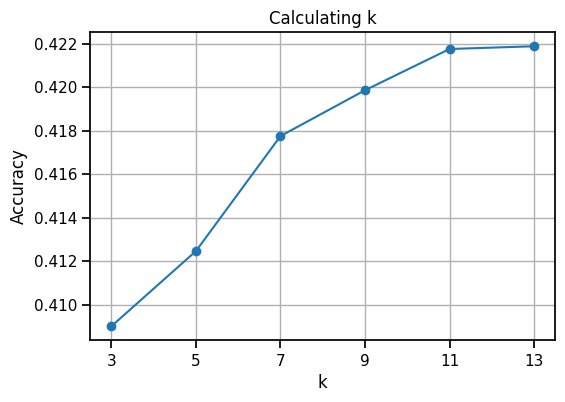

In [230]:
features1 = ["Plx","Vmag","B-V","HvarType"]
data = df_clean[features1].dropna(axis=0)
data1 = data.drop(["HvarType"],axis=1).copy()

X = data1.values
le = LabelEncoder()
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = le.fit_transform(data['HvarType'].values)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=79, stratify=Y)

accs = []
k_values = [3,5,7,9,11,13]
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, Y_train)
    acc = knn_classifier.score(X_test, Y_test)
    accs.append(acc)

plt.figure(figsize=(6,4))
plt.plot(k_values, accs, marker='o')
plt.xticks(k_values)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Calculating k')
plt.grid(True)
plt.show()


In [231]:
knn_best = KNeighborsClassifier(n_neighbors=7)
knn_best.fit(X_train, Y_train)
y_pred = knn_best.predict(X_test)

print(classification_report(Y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

                   0.41      0.53      0.46     18867
           C       0.44      0.46      0.45     19054
           D       0.22      0.06      0.09      4806
           M       0.20      0.04      0.07       447
           P       0.23      0.02      0.04       955
           R       0.29      0.01      0.02       464
           U       0.50      0.26      0.34      2901

    accuracy                           0.42     47494
   macro avg       0.33      0.20      0.21     47494
weighted avg       0.40      0.42      0.39     47494



In [232]:
clf = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 12),
    cv=5,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=[0.0, 0.5, 1.0],      # ridge / elastic / lasso
    multi_class="multinomial",
    class_weight="balanced",        # helps with rare classes
    scoring="f1_macro",             # better than accuracy for imbalance
    max_iter=5000,
    n_jobs=-1,
    refit=True
).fit(X_train, Y_train)

print("Best C:", clf.C_[0], " Best l1_ratio:", clf.l1_ratio_[0])
print("CV f1_macro (train):", clf.score(X_train, Y_train))
print("f1_macro (test):", clf.score(X_train, Y_train))

/Users/dinarazhorabek/Projects/Fall25/astronomy_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best C: 0.6579332246575682  Best l1_ratio: 0.0
CV f1_macro (train): 0.09147766735653627
f1_macro (test): 0.09147766735653627


In [234]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=79)
rf.fit(X_train, Y_train)
print("Test f1_macro:", cross_val_score(rf, X_train, Y_train, cv=5, scoring='f1_macro').mean())


Test f1_macro: 0.21574204820412612
